### Import Relevant Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

### Read in Data

In [3]:
recid = pd.read_csv('cox_violent_parsed.csv')
pd.set_option('display.max_columns', None)

### Data Preprocessing

In [4]:
rows, columns = recid.shape
print(f"The initial dataset has {rows} rows and {columns} columns")

The initial dataset has 18316 rows and 52 columns


In [5]:
rows, columns = recid.shape
print(f"The initial dataset has {rows} rows and {columns} columns")

The initial dataset has 18316 rows and 52 columns


#### Find Initial Columns to Drop

In [6]:
columns_to_drop = ['id','first', 'last', 'start', 'end', 'event', 'violent_recid', 'decile_score.1', 
                   'juv_other_count','juv_misd_count','juv_fel_count', 'r_case_number', 'c_case_number', 
                   'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'priors_count.1', 
                   'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 
                   'r_jail_in', 'r_jail_out', 'c_arrest_date', 'screening_date', 'days_b_screening_arrest']

for column in columns_to_drop:
    if column in recid.columns:
        recid.drop(column, axis=1, inplace=True)

In [7]:
recid.head()

,name,compas_screening_date,sex,dob,age,age_cat,race,decile_score,priors_count,c_jail_in,c_jail_out,c_offense_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,score_text,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody
0,miguel hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20,2013-08-13,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14
1,miguel hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20,2013-08-13,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14
2,michael ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,5,0,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,Risk of Recidivism,Medium,Risk of Violence,2,Low,2014-12-31,2014-12-30,2015-01-03
3,kevon dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,3,0,2013-01-26 03:45:27,2013-02-05 05:36:53,2013-01-26,1.0,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05
4,ed philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,4,4,2013-04-13 04:58:34,2013-04-14 07:02:04,2013-04-13,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16


In [8]:
def get_missing_values_info(df):
    missing_values = df.isnull().sum()
    
    missing_values = missing_values[missing_values > 0]
    
    missing_info_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Values': missing_values.values,
        'Dtype': df.dtypes[missing_values.index].values
    })
    
    return missing_info_df
get_missing_values_info(recid)

,Column,Missing Values,Dtype
0,c_jail_in,1297,object
1,c_jail_out,1297,object
2,c_offense_date,3952,object
3,c_days_from_compas,867,float64
4,c_charge_degree,867,object
5,c_charge_desc,881,object
6,score_text,23,object
7,v_score_text,6,object
8,in_custody,594,object
9,out_custody,594,object


In [9]:
recid

,name,compas_screening_date,sex,dob,age,age_cat,race,decile_score,priors_count,c_jail_in,c_jail_out,c_offense_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,score_text,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody
0,miguel hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20,2013-08-13,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14
1,miguel hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20,2013-08-13,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14
2,michael ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,5,0,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,Risk of Recidivism,Medium,Risk of Violence,2,Low,2014-12-31,2014-12-30,2015-01-03
3,kevon dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,3,0,2013-01-26 03:45:27,2013-02-05 05:36:53,2013-01-26,1.0,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05
4,ed philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,4,4,2013-04-13 04:58:34,2013-04-14 07:02:04,2013-04-13,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,alexsandra beauchamps,2014-12-29,Female,1984-12-21,31,25 - 45,African-American,6,5,2014-12-28 10:14:48,2015-01-07 11:42:43,2014-12-28,1.0,(M1),Battery,0,0,Risk of Recidivism,Medium,Risk of Violence,4,Low,2014-12-29,2014-12-28,2015-01-07
18312,winston gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,1,0,2014-01-13 05:48:01,2014-01-14 07:49:46,2014-01-13,1.0,(F2),Aggravated Battery / Pregnant,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14
18313,farrah jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,2,3,2014-03-08 08:06:02,2014-03-09 12:18:04,2014-03-08,1.0,(M1),Battery on Law Enforc Officer,0,0,Risk of Recidivism,Low,Risk of Violence,2,Low,2014-03-09,2014-03-08,2014-03-09
18314,florencia sanmartin,2014-06-30,Female,1992-12-18,23,Less than 25,Hispanic,4,2,2014-06-28 12:16:41,2014-06-30 11:19:23,2014-06-28,2.0,(F3),Possession of Ethylone,1,0,Risk of Recidivism,Low,Risk of Violence,4,Low,2014-06-30,2015-03-15,2015-03-15


#### Convert DateTime Columns

In [10]:
date_columns = ['compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out', 'c_offense_date', 
                'v_screening_date', 'in_custody', 'out_custody']

for column in date_columns:
    recid[column] = pd.to_datetime(recid[column], errors='coerce')

#### Impute Columns with Missing Values

##### v_score_text and score_text (impute by mode)

In [11]:
v_score_text_mode = recid['v_score_text'].mode()[0]
recid['v_score_text'].fillna(v_score_text_mode, inplace=True)

score_text_mode = recid['score_text'].mode()[0]
recid['score_text'].fillna(score_text_mode, inplace=True)

##### c_jail_in, c_jail_out, c_offense_date (impute by backwords fill)

In [12]:
recid[['c_jail_in', 'c_jail_out']] = recid[['c_jail_in', 'c_jail_out']].bfill()
recid['c_offense_date'] = recid['c_jail_in']

recid[['in_custody', 'out_custody']] = recid[['in_custody', 'out_custody']].bfill()


##### c_days_from_compass

In [13]:
recid['c_days_from_compas'] = recid['c_days_from_compas'].fillna((recid['compas_screening_date'] - recid['c_jail_in']).dt.days)


##### c_charge_degree and c_charge_desc

In [14]:
recid['c_charge_degree'] = recid.groupby(['race', 'age_cat'], group_keys=False)['c_charge_degree'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
recid['c_charge_desc'] = recid.groupby(['race', 'age_cat'], group_keys=False)['c_charge_desc'].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))



In [15]:
recid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   18316 non-null  object        
 1   compas_screening_date  18316 non-null  datetime64[ns]
 2   sex                    18316 non-null  object        
 3   dob                    18316 non-null  datetime64[ns]
 4   age                    18316 non-null  int64         
 5   age_cat                18316 non-null  object        
 6   race                   18316 non-null  object        
 7   decile_score           18316 non-null  int64         
 8   priors_count           18316 non-null  int64         
 9   c_jail_in              18316 non-null  datetime64[ns]
 10  c_jail_out             18316 non-null  datetime64[ns]
 11  c_offense_date         18316 non-null  datetime64[ns]
 12  c_days_from_compas     18316 non-null  float64       
 13  c

### Feature Engineering

#### Create New Features (Drop Unused Features)

In [16]:
recid['age_at_screening'] = (recid['compas_screening_date'] -recid['dob']).dt.days / 365.25

recid['jail_time_days'] = (recid['c_jail_out'] - recid['c_jail_in']).dt.days

recid['custody_time_days'] = (recid['out_custody'] - recid['in_custody']).dt.days


recid['has_priors'] = recid['priors_count'].apply(lambda x: 1 if x > 0 else 0)

recid['violent_recidivism'] = recid.apply(lambda x: 'violent' if x['is_violent_recid'] == 1 else 'non-violent' if x['is_recid'] == 1 else 'non_violent', axis=1)


#### Drop rows where no information on recidivism or decile score

In [17]:
recid = recid.loc[(recid["is_recid"]!=-1) & (recid["decile_score"]!=-1) & (recid["v_decile_score"] !=-1)]

#### Drop rows where cases have been evaluated more than 45 days for case relevancy

In [18]:
recid = recid.loc[(recid["c_days_from_compas"] <30) & (recid["c_days_from_compas"] > -30)]

### Perform EDA

#### Age Distribution

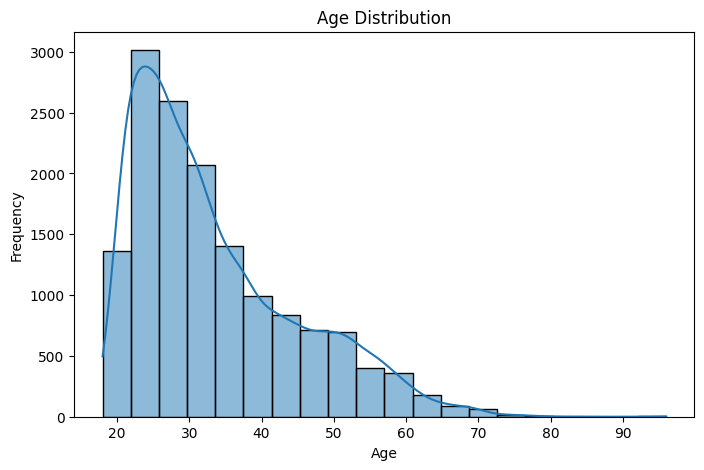

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(recid['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#### Recidivism by Race

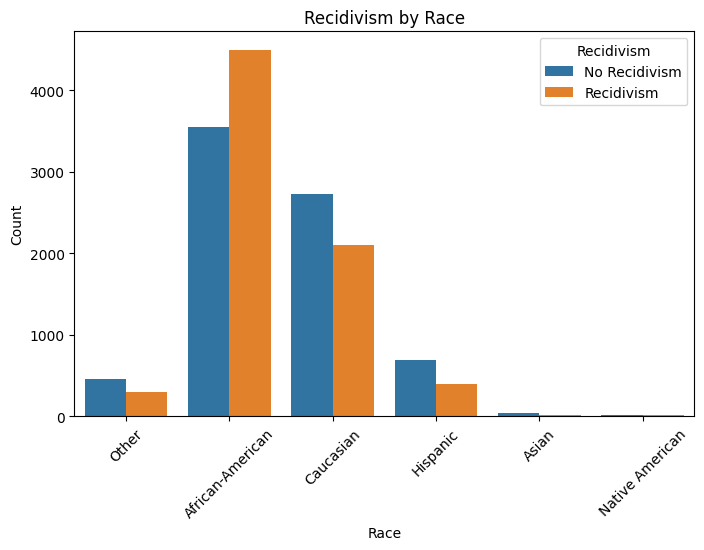

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(x='race', hue='is_recid', data=recid)
plt.title('Recidivism by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Recidivism', labels=['No Recidivism', 'Recidivism'])
plt.show()

#### Recidivism by Gender

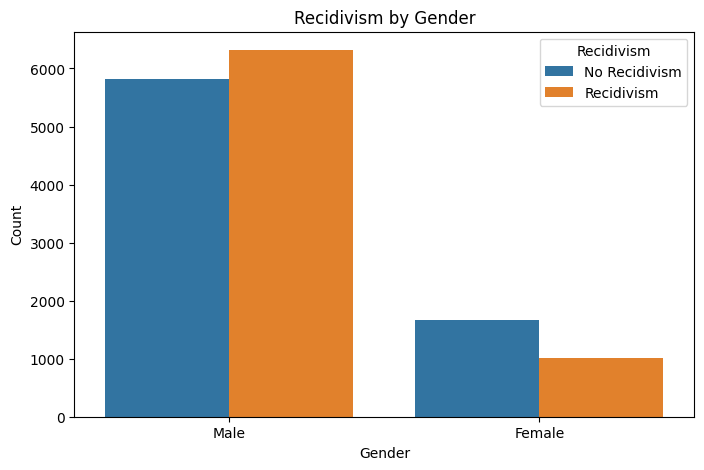

In [31]:
plt.figure(figsize=(8,5))
sns.countplot(x='sex', hue='is_recid', data=recid)
plt.title('Recidivism by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Recidivism', labels=['No Recidivism', 'Recidivism'])
plt.show()

#### Priors Count vs. Recidivism

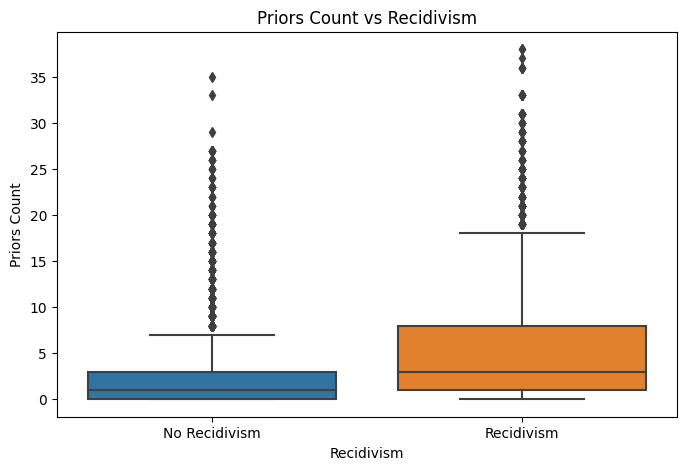

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_recid', y='priors_count', data=recid)
plt.title('Priors Count vs Recidivism')
plt.xlabel('Recidivism')
plt.ylabel('Priors Count')
plt.xticks([0, 1], ['No Recidivism', 'Recidivism'])
plt.show()

#### Decile Score vs. Recidivism

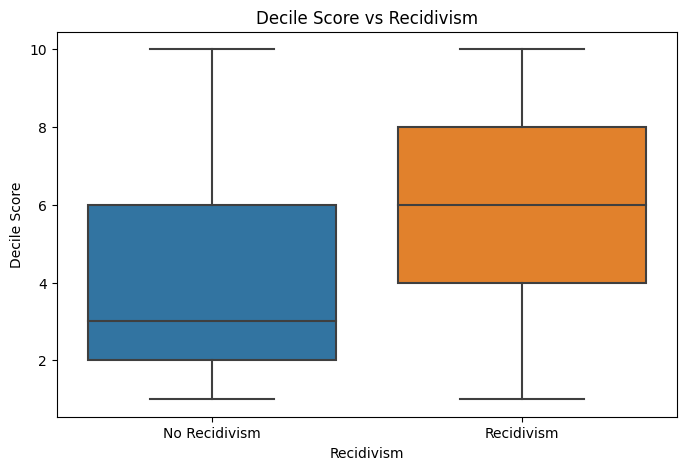

In [40]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_recid', y='decile_score', data=recid)
plt.title('Decile Score vs Recidivism')
plt.xlabel('Recidivism')
plt.ylabel('Decile Score')
plt.xticks([0, 1], ['No Recidivism', 'Recidivism'])
plt.show()


#### Boxplot of Decile Score and Race

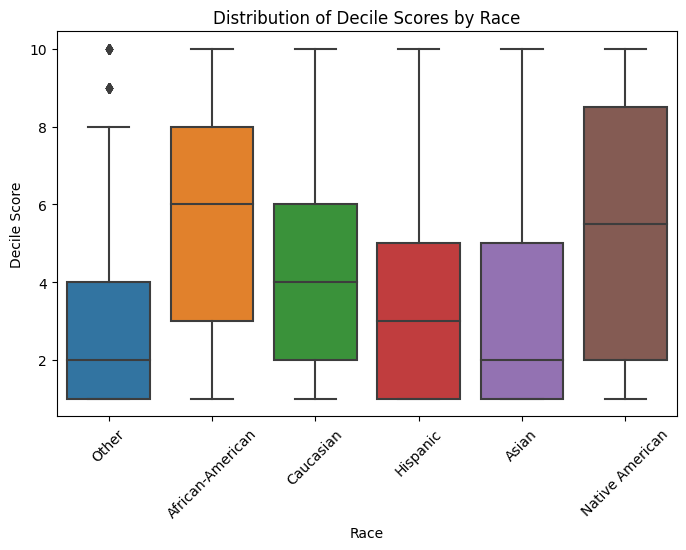

In [50]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=recid, x='race', y='decile_score')
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Race')
plt.ylabel('Decile Score')
plt.xticks(rotation=45)
plt.show()

#### Correlation Heatmap

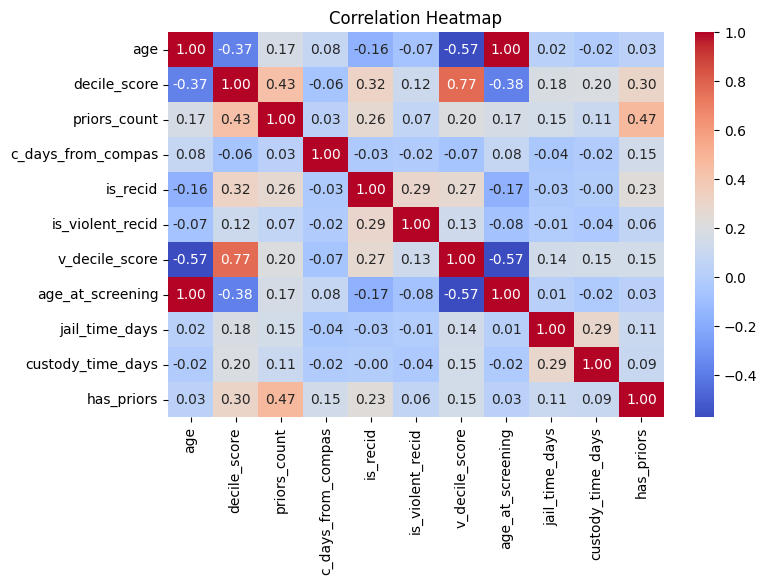

In [43]:
plt.figure(figsize=(8, 5))
corr = recid.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

<Figure size 1200x600 with 0 Axes>

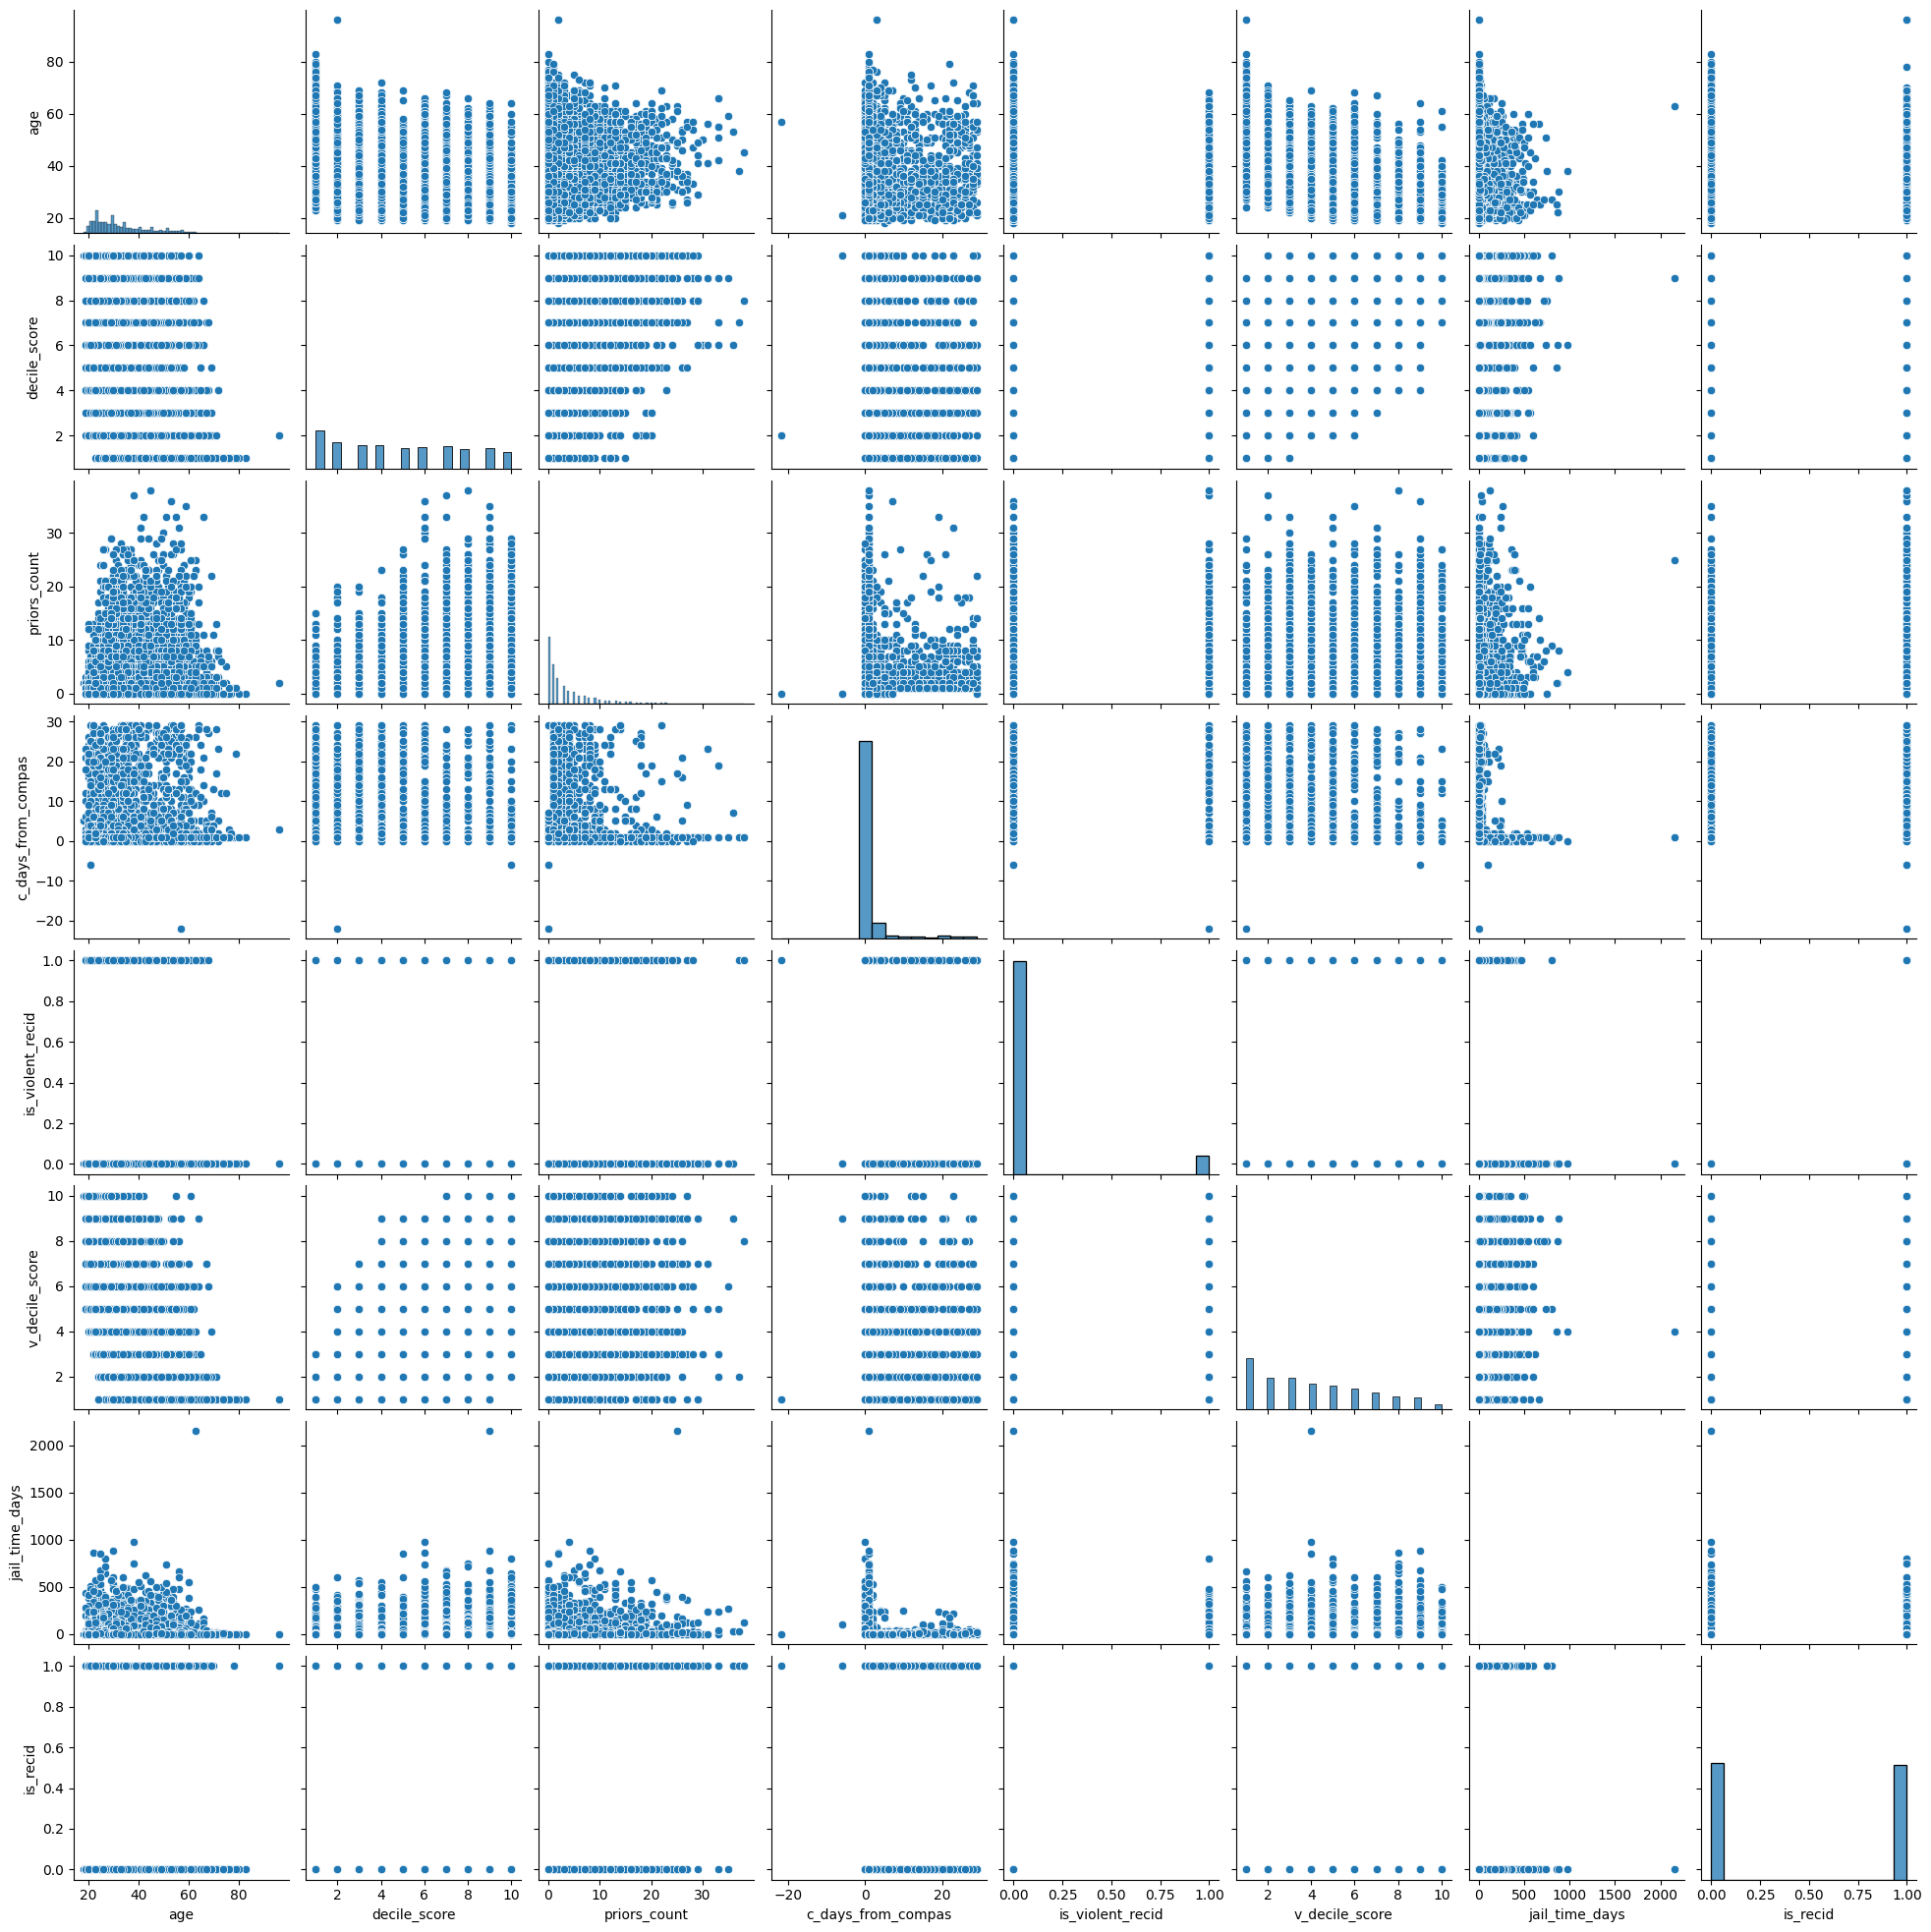

In [46]:
plt.figure(figsize=(12, 6))
sns.pairplot(recid[['age', 'decile_score', 'priors_count', 'c_days_from_compas', 'is_violent_recid', 'v_decile_score', 'jail_time_days', 'is_recid']])
plt.show()

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

label_encoder = LabelEncoder()
scaler = StandardScaler()

recid['sex'].replace({'Male': 1, 'Female': 0}, inplace=True)

X = recid[['age', 'sex', 'decile_score', 'priors_count', 'race', 'jail_time_days', 'c_days_from_compas', 'is_violent_recid', 'v_decile_score']]
Y = recid['is_recid']

X_encoded = X.copy()
X_encoded['race_encoded'] = label_encoder.fit_transform(X['race'])
X_encoded.drop(['race'], axis=1, inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, stratify=Y, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

kfold = StratifiedKFold(n_splits=5)

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Y_pred = grid_search.best_estimator_.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Best Hyperparameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Confusion Matrix:
 [[1327  170]
 [ 124 1342]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1497
           1       0.89      0.92      0.90      1466

    accuracy                           0.90      2963
   macro avg       0.90      0.90      0.90      2963
weighted avg       0.90      0.90      0.90      2963

Test Accuracy: 0.9008


In [89]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', RandomForestClassifier())  
])

param_grid = {
    'clf__n_estimators': [50, 100, 200], 
    'clf__max_depth': [None, 5, 10],  
    'clf__min_samples_split': [2, 5, 10]  
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

Best Hyperparameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Best Accuracy: 0.8722582114758678
